# Part 9. Avoid downgoing edges

In the previous part, we've found that `tube` may mistakingly place some nodes lower than their children. Let's make this defect visible and fix it.

In [1]:
# Rendering defaults
WIDTH = 5

In [2]:
import matplotlib.pyplot as plt
from enum import IntEnum
from dataclasses import dataclass, field, replace
from operator import itemgetter
from random import randint
from typing import Any, Dict, List, Set, Union, Optional

SiebenApp classes:

In [3]:
# One of two supported edge types
class EdgeType(IntEnum):
    BLOCKER = 1
    PARENT = 2

# Edge between two goals (wow, it doesn't use GoalId, right?)
@dataclass(frozen=True)
class Edge:
    source: int
    target: int
    type: EdgeType

# For legacy reasons, goal id may be either integer (real or pseudo goal) or string (pseudo goal only)
GoalId = Union[str, int]

# Single row of "render result" (well, actually, it's a single goal)
@dataclass(frozen=True)
class RenderRow:
    """Strongly typed rendered representation of a single goal."""

    goal_id: GoalId
    raw_id: int
    name: str
    is_open: bool
    is_switchable: bool
    edges: list[tuple[GoalId, EdgeType]]
    attrs: dict[str, str] = field(default_factory=lambda: {})

# A whole result of "rendering" (also suitable for result returned by a single request to goal tree)
@dataclass
class RenderResult:
    rows: list[RenderRow]
    edge_opts: dict[str, tuple[int, int, int]]
    select: tuple[GoalId, GoalId]
    node_opts: dict[GoalId, Any]
    roots: set[GoalId]
    index: dict[GoalId, int]

    def __init__(
        self,
        rows: list[RenderRow],
        edge_opts: Optional[dict[str, tuple[int, int, int]]] = None,
        select: Optional[tuple[GoalId, GoalId]] = None,
        node_opts: Optional[dict[GoalId, Any]] = None,
        roots: Optional[set[GoalId]] = None,
    ):
        self.rows = rows
        self.edge_opts = edge_opts or {}
        self.select = select or (0, 0)
        self.node_opts = node_opts or {}
        self.roots = roots or set()
        self.index = {row.goal_id: i for i, row in enumerate(rows)}

    def goals(self):
        return [
            (goal_id, attrs)
            for goal_id, attrs in self.node_opts.items()
            if isinstance(goal_id, int)
        ]

    def by_id(self, goal_id: GoalId) -> RenderRow:
        assert goal_id in self.index
        return self.rows[self.index[goal_id]]


Drawing function, improved to print downgoing edges.

In [7]:
def draw(rr: RenderResult, min_row: int = 0) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for goal_id, attrs in rr.goals():
        row, col = attrs.get("row", None), attrs.get("col", None)
        xpos[goal_id] = col if col is not None else randint(0, 10)
        ypos[goal_id] = row if row is not None else randint(min_row, 10) 
    for row in rr.rows:
        row_id = row.goal_id
        for edge in row.edges:
            e = edge[0]
            if ypos[row_id] > ypos[e]:
                print(f"downgoing edge: {row_id}@{ypos[row_id]} -> {e}@{ypos[e]}")
            plt.plot([xpos[row_id], xpos[e]], [ypos[row_id], ypos[e]], 'ro-')
        plt.text(xpos[row_id] + 0.1, ypos[row_id], row.name)
    tops = [row.goal_id for row in rr.rows if row.is_switchable]
    plt.plot([xpos[t] for t in tops], [ypos[t] for t in tops], 'bo')
    plt.draw()

A graph to render.

In [5]:
rr0 = RenderResult(rows=[RenderRow(goal_id=1, raw_id=1, name='node 1', is_open=True, is_switchable=False, edges=[(2, EdgeType.PARENT), (3, EdgeType.PARENT), (4, EdgeType.PARENT), (5, EdgeType.PARENT), (40, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=2, raw_id=2, name='node 2', is_open=True, is_switchable=True, edges=[(43, EdgeType.PARENT), (44, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=3, raw_id=3, name='node 3', is_open=True, is_switchable=False, edges=[(6, EdgeType.BLOCKER), (7, EdgeType.BLOCKER), (8, EdgeType.BLOCKER), (30, EdgeType.PARENT), (37, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=4, raw_id=4, name='node 4', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=5, raw_id=5, name='node 5', is_open=True, is_switchable=False, edges=[(6, EdgeType.PARENT), (7, EdgeType.PARENT), (8, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=6, raw_id=6, name='node 6', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=7, raw_id=7, name='node 7', is_open=True, is_switchable=False, edges=[(9, EdgeType.BLOCKER), (16, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=8, raw_id=8, name='node 8', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=9, raw_id=9, name='node 9', is_open=True, is_switchable=False, edges=[(10, EdgeType.PARENT), (11, EdgeType.PARENT), (12, EdgeType.PARENT), (13, EdgeType.PARENT), (14, EdgeType.PARENT), (15, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=10, raw_id=10, name='node 10', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=11, raw_id=11, name='node 11', is_open=False, is_switchable=True, edges=[(51, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=12, raw_id=12, name='node 12', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=13, raw_id=13, name='node 13', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=14, raw_id=14, name='node 14', is_open=False, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=15, raw_id=15, name='node 15', is_open=True, is_switchable=True, edges=[(51, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=16, raw_id=16, name='node 16', is_open=False, is_switchable=True, edges=[(17, EdgeType.PARENT), (18, EdgeType.PARENT), (19, EdgeType.PARENT), (20, EdgeType.PARENT), (24, EdgeType.PARENT), (25, EdgeType.PARENT), (26, EdgeType.PARENT), (27, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=17, raw_id=17, name='node 17', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=18, raw_id=18, name='node 18', is_open=False, is_switchable=False, edges=[(23, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=19, raw_id=19, name='node 19', is_open=False, is_switchable=False, edges=[(21, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=20, raw_id=20, name='node 20', is_open=False, is_switchable=False, edges=[(21, EdgeType.PARENT), (22, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=21, raw_id=21, name='node 21', is_open=False, is_switchable=False, edges=[(38, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=22, raw_id=22, name='node 22', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=23, raw_id=23, name='node 23', is_open=False, is_switchable=False, edges=[(38, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=24, raw_id=24, name='node 24', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=25, raw_id=25, name='node 25', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=26, raw_id=26, name='node 26', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=27, raw_id=27, name='node 27', is_open=False, is_switchable=False, edges=[(18, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=28, raw_id=28, name='node 28', is_open=False, is_switchable=True, edges=[(29, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=29, raw_id=29, name='node 29', is_open=False, is_switchable=False, edges=[(45, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=30, raw_id=30, name='node 30', is_open=True, is_switchable=True, edges=[(31, EdgeType.PARENT), (32, EdgeType.PARENT), (33, EdgeType.PARENT), (34, EdgeType.PARENT), (35, EdgeType.PARENT), (36, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=31, raw_id=31, name='node 31', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=32, raw_id=32, name='node 32', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=33, raw_id=33, name='node 33', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=34, raw_id=34, name='node 34', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=35, raw_id=35, name='node 35', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=36, raw_id=36, name='node 36', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=37, raw_id=37, name='node 37', is_open=True, is_switchable=False, edges=[(9, EdgeType.PARENT), (16, EdgeType.PARENT), (28, EdgeType.PARENT), (42, EdgeType.PARENT), (46, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=38, raw_id=38, name='node 38', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=39, raw_id=39, name='node 39', is_open=False, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=40, raw_id=40, name='node 40', is_open=True, is_switchable=False, edges=[(39, EdgeType.PARENT), (41, EdgeType.BLOCKER)], attrs={}), RenderRow(goal_id=41, raw_id=41, name='node 41', is_open=True, is_switchable=True, edges=[], attrs={}), RenderRow(goal_id=42, raw_id=42, name='node 42', is_open=False, is_switchable=True, edges=[(43, EdgeType.BLOCKER), (44, EdgeType.BLOCKER), (49, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=43, raw_id=43, name='node 43', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=44, raw_id=44, name='node 44', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=45, raw_id=45, name='node 45', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=46, raw_id=46, name='node 46', is_open=False, is_switchable=True, edges=[(47, EdgeType.PARENT), (48, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=47, raw_id=47, name='node 47', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=48, raw_id=48, name='node 48', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=49, raw_id=49, name='node 49', is_open=False, is_switchable=False, edges=[(50, EdgeType.PARENT)], attrs={}), RenderRow(goal_id=50, raw_id=50, name='node 50', is_open=False, is_switchable=False, edges=[], attrs={}), RenderRow(goal_id=51, raw_id=51, name='node 51', is_open=False, is_switchable=False, edges=[], attrs={})], select=(1, 1), roots={1}, node_opts={1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26:{}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}, 41: {}, 42: {}, 43: {}, 44: {}, 45: {}, 46: {}, 47: {}, 48: {}, 49: {}, 50: {}, 51: {}})

downgoing edge: 1@5 -> 2@4
downgoing edge: 1@5 -> 4@3
downgoing edge: 1@5 -> 5@2
downgoing edge: 1@5 -> 40@2
downgoing edge: 2@4 -> 43@2
downgoing edge: 3@9 -> 6@3
downgoing edge: 3@9 -> 8@7
downgoing edge: 3@9 -> 30@7
downgoing edge: 7@10 -> 9@4
downgoing edge: 7@10 -> 16@4
downgoing edge: 9@4 -> 11@0
downgoing edge: 9@4 -> 14@2
downgoing edge: 9@4 -> 15@1
downgoing edge: 10@7 -> 51@6
downgoing edge: 12@8 -> 51@6
downgoing edge: 13@9 -> 51@6
downgoing edge: 16@4 -> 17@2
downgoing edge: 16@4 -> 24@2
downgoing edge: 16@4 -> 27@2
downgoing edge: 19@7 -> 21@3
downgoing edge: 20@7 -> 21@3
downgoing edge: 20@7 -> 22@3
downgoing edge: 25@10 -> 18@5
downgoing edge: 26@7 -> 18@5
downgoing edge: 28@2 -> 29@0
downgoing edge: 30@7 -> 31@5
downgoing edge: 30@7 -> 33@6
downgoing edge: 37@10 -> 9@4
downgoing edge: 37@10 -> 16@4
downgoing edge: 37@10 -> 28@2
downgoing edge: 37@10 -> 42@9
downgoing edge: 37@10 -> 46@6
downgoing edge: 42@9 -> 43@2
downgoing edge: 42@9 -> 44@7
downgoing edge: 42@9 -> 49

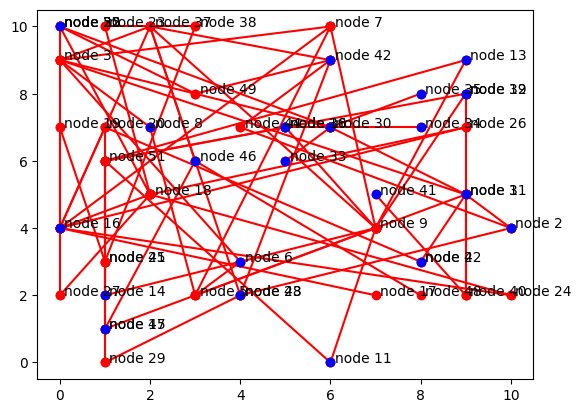

In [8]:
draw(rr0)

A lot of downgoing edges, as expected. Nodes are placed at random, ignoring ordering.

## Discover an issue

Let's roll few iterations of rendering using a previous algorithm version.

In [36]:
@dataclass
class RenderStep:
    rr: RenderResult
    roots: List[int]
    layers: List[List[int]]
    previous: Dict[int, List[int]]    # new field, see description below

In [20]:
def pp(step: RenderStep):
    return [step.roots, step.layers]

In [13]:
def add_if_not(m: Dict, m1: Dict) -> Dict:
    nm = dict(m)
    for k, v in m1.items():
        if nm.get(k, None) is None:
            nm[k] = v
    return nm

In [43]:
def tube0(step: RenderStep):
    children_of_new_layer: Set[int] = set()
    new_layer: List[int] = []
    for goal_id in step.roots:
        if len(new_layer) >= WIDTH:
            break
        if goal_id not in children_of_new_layer:
            new_layer.append(goal_id)
            children_of_new_layer.update(e[0] for e in step.rr.by_id(goal_id).edges)
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    new_layers = step.layers + [new_layer]
    already_added: Set[int] = {g for l in new_layers for g in l}
    filtered_roots: List[int] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(g)
            already_added.add(g)
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers,
            step.previous)         # for structural compatibility with new class definition

In [62]:
step_0_1 = tube0(RenderStep(rr0, list(rr0.roots), [], []))
step_0_2 = tube0(step_0_1)
step_0_3 = tube0(step_0_2)
step_0_4 = tube0(step_0_3)
step_0_5 = tube0(step_0_4)

downgoing edge: 9@4 -> 12@1
downgoing edge: 11@10 -> 51@9
downgoing edge: 16@4 -> 19@1
downgoing edge: 16@4 -> 25@2
downgoing edge: 18@9 -> 23@6
downgoing edge: 19@1 -> 21@0
downgoing edge: 20@8 -> 21@0
downgoing edge: 20@8 -> 22@4
downgoing edge: 23@6 -> 38@2
downgoing edge: 27@10 -> 18@9
downgoing edge: 28@10 -> 29@2
downgoing edge: 42@4 -> 43@2
downgoing edge: 42@4 -> 44@2
downgoing edge: 46@3 -> 48@1
downgoing edge: 49@10 -> 50@8


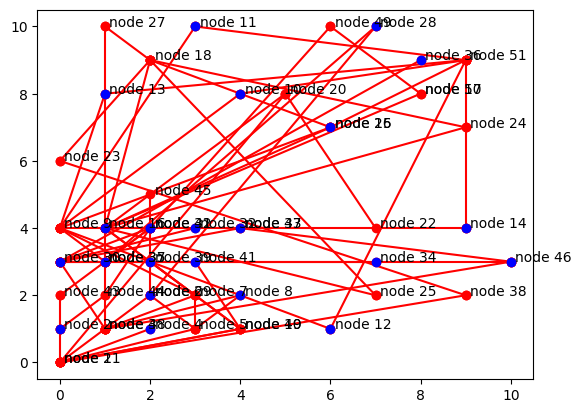

In [63]:
draw(step_0_5.rr)

Among fake messages, we got a real one:
```
downgoing edge: 42@4 -> 43@2
downgoing edge: 42@4 -> 44@2
```
Nodes 43 and 44 was already placed before the node 42. It's not good because they should be higher.

In [18]:
step_0_5.rr.by_id(42).edges

[(43, <EdgeType.BLOCKER: 1>),
 (44, <EdgeType.BLOCKER: 1>),
 (49, <EdgeType.PARENT: 2>)]

## Calculate parents for each node

Such issue don't exist in the current implementation of SiebenApp rendering, because it iterates from leaves to root. A new algorithm iterates from root to leaves. Therefore, we must have some additional knowledge about each node to understand which goals are allowed to put onto the current layer, and which are not allowed.

We would track a list of "previous" nodes for every node. We should allow to place a new node only when all "previous" nodes are already placed. It would be added as a new field `previous` to `RenderStep` class.

In [37]:
def find_previous(rr: RenderResult) -> Dict[int, List[int]]:
    result: Dict[int, List[int]] = {g: [] for g in rr.roots}
    to_visit: Set[int] = set(rr.roots)
    while to_visit:
        g = to_visit.pop()
        connections = [e[0] for e in rr.by_id(g).edges]
        for g1 in connections:
            to_visit.add(g1)
            result[g1] = result.get(g1, []) + [g]
    return result

In [40]:
find_previous(rr0)

{1: [],
 2: [1],
 3: [1],
 4: [1],
 5: [1],
 40: [1],
 43: [2, 42],
 44: [2, 42],
 6: [3, 5],
 7: [3, 5],
 8: [3, 5],
 30: [3],
 37: [3],
 9: [7, 37],
 16: [7, 37],
 39: [40],
 41: [40],
 28: [37],
 42: [37],
 46: [37],
 17: [16],
 18: [16, 24, 25, 26, 27],
 19: [16],
 20: [16],
 24: [16],
 25: [16],
 26: [16],
 27: [16],
 23: [18, 18],
 21: [19, 20],
 22: [20],
 38: [21, 23, 23],
 29: [28],
 31: [30],
 32: [30],
 33: [30],
 34: [30],
 35: [30],
 36: [30],
 45: [29],
 49: [42],
 47: [46],
 48: [46],
 50: [49],
 10: [9],
 11: [9],
 12: [9],
 13: [9],
 14: [9],
 15: [9],
 51: [10, 11, 12, 13, 14, 15]}

Now we have all data required to craft a new version of algorithm. At every step, we place only nodes that have "previous" nodes being placed at some of the previous steps.

In [51]:
def tube(step: RenderStep):
    children_of_new_layer: Set[int] = set()
    new_layer: List[int] = []
    # Tracking already added nodes. Not optimal but OK for now
    already_added: Set[int] = set(g for l in step.layers for g in l)
    # End of tracking
    for goal_id in step.roots:
        if len(new_layer) >= WIDTH:
            break
        if (goal_id not in children_of_new_layer) and \
            (all(g in already_added for g in step.previous[goal_id])):          # a new check
            new_layer.append(goal_id)
            children_of_new_layer.update(e[0] for e in step.rr.by_id(goal_id).edges)
    new_roots: List[int] = step.roots[len(new_layer):] + \
                            [e[0] for gid in new_layer for e in step.rr.by_id(gid).edges]
    new_opts: Dict[int, Dict] = {
        goal_id: add_if_not(opts, {
            "row": len(step.layers) if goal_id in new_layer else None,
            "col": new_layer.index(goal_id) if goal_id in new_layer else None
        })
        for goal_id, opts in step.rr.node_opts.items()
    }
    new_layers = step.layers + [new_layer]
    already_added.update(set(g for l in new_layers for g in l))
    filtered_roots: List[int] = []
    for g in new_roots:
        if g not in already_added:
            filtered_roots.append(g)
            already_added.add(g)
    
    return RenderStep(
            RenderResult(step.rr.rows, node_opts=new_opts, select=step.rr.select, roots=step.rr.roots),
            filtered_roots,
            new_layers,
            step.previous)

Let's go!

### Steps 1-3

In [52]:
step_1_1 = tube(RenderStep(rr0, list(rr0.roots), [], find_previous(rr0)))
pp(step_0_1), pp(step_1_1)

([[2, 3, 4, 5, 40], [[1]]], [[2, 3, 4, 5, 40], [[1]]])

No difference yet.

In [53]:
step_1_2 = tube(step_1_1)
pp(step_0_2), pp(step_1_2)

([[43, 44, 6, 7, 8, 30, 37, 39, 41], [[1], [2, 3, 4, 5, 40]]],
 [[43, 44, 6, 7, 8, 30, 37, 39, 41], [[1], [2, 3, 4, 5, 40]]])

No difference yet.

In [54]:
step_1_3 = tube(step_1_2)
pp(step_0_3), pp(step_1_3)

([[30, 37, 39, 41, 9, 16], [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8]]],
 [[39, 41, 9, 16, 31, 32, 33, 34, 35, 36, 28, 42, 46],
  [[1], [2, 3, 4, 5, 40], [6, 7, 8, 30, 37]]])

Now we have changes! Nodes 43 and 44 were not placed to the new level, and that's good. Instead, it has become possible to take nodes 30 and 37 to this layer. As a result, we got two different queues now. Structure of two rendered graphs would diverse more and more. We wouldn't draw them right now, let's run few more iterations instead.

### Steps 4-x

In [55]:
step_1_4 = tube(step_1_3)
pp(step_0_4), pp(step_1_4)

([[9, 16, 31, 32, 33, 34, 35, 36, 28, 42, 46],
  [[1], [2, 3, 4, 5, 40], [43, 44, 6, 7, 8], [30, 37, 39, 41]]],
 [[32,
   33,
   34,
   35,
   36,
   28,
   42,
   46,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27],
  [[1], [2, 3, 4, 5, 40], [6, 7, 8, 30, 37], [39, 41, 9, 16, 31]]])

In [56]:
step_1_5 = tube(step_1_4)
pp(step_0_5), pp(step_1_5)

([[34,
   35,
   36,
   28,
   42,
   46,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   24,
   25,
   26,
   27],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33]]],
 [[28, 42, 46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36]]])

downgoing edge: 9@4 -> 10@2
downgoing edge: 9@4 -> 14@1
downgoing edge: 10@2 -> 51@1
downgoing edge: 11@10 -> 51@1
downgoing edge: 12@10 -> 51@1
downgoing edge: 13@5 -> 51@1
downgoing edge: 15@9 -> 51@1
downgoing edge: 16@4 -> 17@1
downgoing edge: 16@4 -> 18@3
downgoing edge: 16@4 -> 19@0
downgoing edge: 16@4 -> 20@0
downgoing edge: 16@4 -> 25@0
downgoing edge: 16@4 -> 26@0
downgoing edge: 16@4 -> 27@3
downgoing edge: 18@3 -> 23@1
downgoing edge: 24@5 -> 18@3
downgoing edge: 29@9 -> 45@6
downgoing edge: 37@3 -> 28@2
downgoing edge: 42@6 -> 43@2
downgoing edge: 42@6 -> 44@2
downgoing edge: 42@6 -> 49@4
downgoing edge: 46@8 -> 47@6
downgoing edge: 46@8 -> 48@3


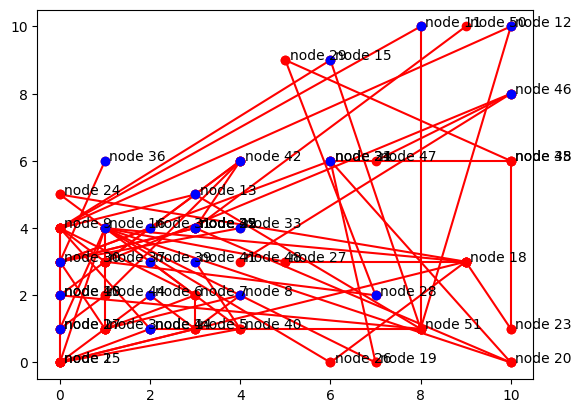

In [58]:
draw(step_0_5.rr)

downgoing edge: 2@1 -> 44@0
downgoing edge: 9@3 -> 10@0
downgoing edge: 9@3 -> 13@0
downgoing edge: 9@3 -> 15@2
downgoing edge: 16@3 -> 17@0
downgoing edge: 16@3 -> 25@0
downgoing edge: 18@10 -> 23@8
downgoing edge: 20@10 -> 21@9
downgoing edge: 20@10 -> 22@0
downgoing edge: 28@10 -> 29@6
downgoing edge: 29@6 -> 45@2
downgoing edge: 42@8 -> 43@2
downgoing edge: 42@8 -> 44@0
downgoing edge: 42@8 -> 49@4


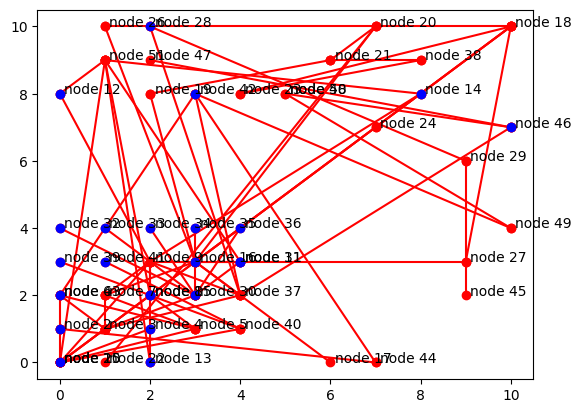

In [59]:
draw(step_1_5.rr)

Not descriptive yet, run more iterations.

In [64]:
step_0_6 = tube0(step_0_5)
step_1_6 = tube(step_1_5)
pp(step_0_6), pp(step_1_6)

([[46, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42]]],
 [[12, 13, 14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 43, 44, 49, 47, 48, 51],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [28, 42, 46, 10, 11]]])

In [66]:
step_0_7 = tube0(step_0_6)
step_1_7 = tube(step_1_6)
pp(step_0_7), pp(step_1_7)

([[14, 15, 17, 18, 19, 20, 24, 25, 26, 27, 29, 49, 47, 48, 51],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13]]],
 [[18, 19, 20, 24, 25, 26, 27, 29, 43, 44, 49, 47, 48, 51],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [28, 42, 46, 10, 11],
   [12, 13, 14, 15, 17]]])

In [67]:
step_0_8 = tube0(step_0_7)
step_1_8 = tube(step_1_7)
pp(step_0_8), pp(step_1_8)

([[20, 24, 25, 26, 27, 29, 49, 47, 48, 51, 23, 21],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19]]],
 [[27, 29, 43, 44, 49, 47, 48, 51, 21, 22, 18],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [28, 42, 46, 10, 11],
   [12, 13, 14, 15, 17],
   [19, 20, 24, 25, 26]]])

downgoing edge: 14@7 -> 51@6
downgoing edge: 15@7 -> 51@6
downgoing edge: 16@4 -> 20@1
downgoing edge: 16@4 -> 27@3
downgoing edge: 19@7 -> 21@6
downgoing edge: 21@6 -> 38@3
downgoing edge: 23@9 -> 38@3
downgoing edge: 26@10 -> 18@7
downgoing edge: 28@5 -> 29@2
downgoing edge: 42@5 -> 43@2
downgoing edge: 42@5 -> 44@2
downgoing edge: 42@5 -> 49@3
downgoing edge: 46@6 -> 47@0
downgoing edge: 49@3 -> 50@1


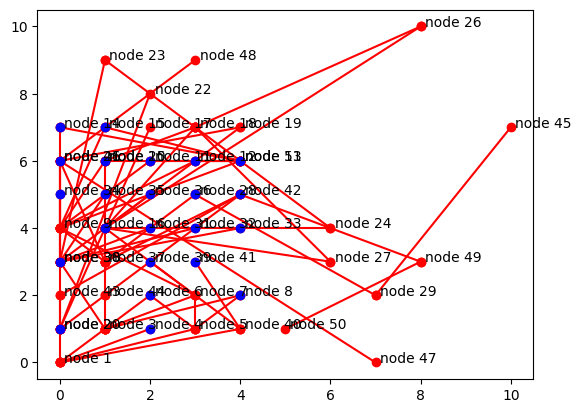

In [68]:
draw(step_0_8.rr)

downgoing edge: 10@5 -> 51@4
downgoing edge: 11@5 -> 51@4
downgoing edge: 12@6 -> 51@4
downgoing edge: 13@6 -> 51@4
downgoing edge: 14@6 -> 51@4
downgoing edge: 15@6 -> 51@4
downgoing edge: 18@8 -> 23@6
downgoing edge: 19@7 -> 21@3
downgoing edge: 20@7 -> 21@3
downgoing edge: 20@7 -> 22@0
downgoing edge: 42@5 -> 43@4
downgoing edge: 42@5 -> 49@1
downgoing edge: 46@5 -> 47@4
downgoing edge: 46@5 -> 48@2


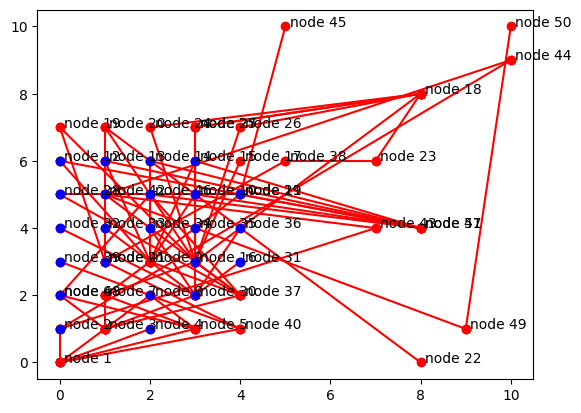

In [69]:
draw(step_1_8.rr)

Still too much mess, continue.

In [70]:
step_0_9 = tube0(step_0_8)
step_1_9 = tube(step_1_8)
pp(step_0_9), pp(step_1_9)

([[29, 49, 47, 48, 51, 23, 21, 22],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19],
   [20, 24, 25, 26, 27]]],
 [[47, 48, 51, 21, 22, 18, 45, 50],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [28, 42, 46, 10, 11],
   [12, 13, 14, 15, 17],
   [19, 20, 24, 25, 26],
   [27, 29, 43, 44, 49]]])

In [71]:
step_0_10 = tube0(step_0_9)
step_1_10 = tube(step_1_9)
pp(step_0_10), pp(step_1_10)

([[23, 21, 22, 45, 50],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19],
   [20, 24, 25, 26, 27],
   [29, 49, 47, 48, 51]]],
 [[18, 45, 50, 38],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [28, 42, 46, 10, 11],
   [12, 13, 14, 15, 17],
   [19, 20, 24, 25, 26],
   [27, 29, 43, 44, 49],
   [47, 48, 51, 21, 22]]])

In [72]:
step_0_11 = tube0(step_0_10)
step_1_11 = tube(step_1_10)
pp(step_0_11), pp(step_1_11)

([[38],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19],
   [20, 24, 25, 26, 27],
   [29, 49, 47, 48, 51],
   [23, 21, 22, 45, 50]]],
 [[38, 23],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [28, 42, 46, 10, 11],
   [12, 13, 14, 15, 17],
   [19, 20, 24, 25, 26],
   [27, 29, 43, 44, 49],
   [47, 48, 51, 21, 22],
   [18, 45, 50]]])

In [73]:
step_0_12 = tube0(step_0_11)
step_1_12 = tube(step_1_11)
pp(step_0_12), pp(step_1_12)

([[],
  [[1],
   [2, 3, 4, 5, 40],
   [43, 44, 6, 7, 8],
   [30, 37, 39, 41],
   [9, 16, 31, 32, 33],
   [34, 35, 36, 28, 42],
   [46, 10, 11, 12, 13],
   [14, 15, 17, 18, 19],
   [20, 24, 25, 26, 27],
   [29, 49, 47, 48, 51],
   [23, 21, 22, 45, 50],
   [38]]],
 [[38],
  [[1],
   [2, 3, 4, 5, 40],
   [6, 7, 8, 30, 37],
   [39, 41, 9, 16, 31],
   [32, 33, 34, 35, 36],
   [28, 42, 46, 10, 11],
   [12, 13, 14, 15, 17],
   [19, 20, 24, 25, 26],
   [27, 29, 43, 44, 49],
   [47, 48, 51, 21, 22],
   [18, 45, 50],
   [23]]])

Done for the previous function, but not for the new one. Node 38 could only be placed in the next iteration.

In [75]:
step_1_13 = tube(step_1_12)
pp(step_1_13)

[[],
 [[1],
  [2, 3, 4, 5, 40],
  [6, 7, 8, 30, 37],
  [39, 41, 9, 16, 31],
  [32, 33, 34, 35, 36],
  [28, 42, 46, 10, 11],
  [12, 13, 14, 15, 17],
  [19, 20, 24, 25, 26],
  [27, 29, 43, 44, 49],
  [47, 48, 51, 21, 22],
  [18, 45, 50],
  [23],
  [38]]]

downgoing edge: 24@8 -> 18@7
downgoing edge: 25@8 -> 18@7
downgoing edge: 26@8 -> 18@7
downgoing edge: 27@8 -> 18@7
downgoing edge: 42@5 -> 43@2
downgoing edge: 42@5 -> 44@2


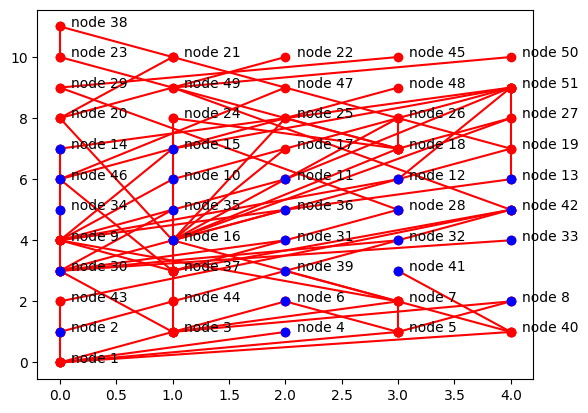

In [76]:
draw(step_0_12.rr)

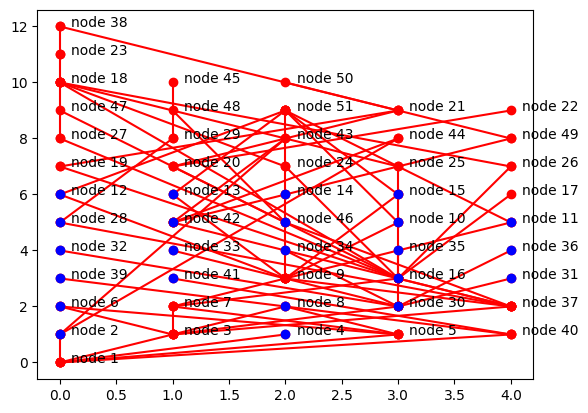

In [77]:
draw(step_1_13.rr)

We got 6 downgoing edges for the previous version, and 0 for the current. Looks like a wictory.

### Beautify

Again, let's take a look how this rendered graph would look after horizontal adjustments.

In [79]:
def avg(vals):
    return sum(vals) / len(vals)

def shift_neutral(ds):
    return avg([d[1] for d in ds])

def calc_shift(rr: RenderResult, shift_fn):
    connected: Dict[int, Set[int]] = {row.goal_id: set() for row in rr.rows}
    for row in rr.rows:
        for e in row.edges:
            connected[e[0]].add(row.goal_id)
            connected[row.goal_id].add(e[0])

    result = {}
    for row in rr.rows:
        goal_id = row.goal_id
        opts = rr.node_opts[goal_id]
        row_, col_ = opts['row'], opts['col']
        deltas = [
            (rr.node_opts[c]['row'] - row_,
             rr.node_opts[c]['col'] - col_)
            for c in connected[goal_id]
        ]
        result[goal_id] = shift_fn(deltas)
    return result

def adjust_horisontal(rr: RenderResult, mult):
    deltas = calc_shift(rr, shift_neutral)
    new_opts = {
        goal_id: opts | {"col": opts["col"] + (mult * deltas[goal_id])}
        for goal_id, opts in rr.node_opts.items()
    }
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

def normalize_cols(rr: RenderResult) -> RenderResult:
    order0 = {}
    for goal_id, opts in rr.node_opts.items():
        row, col = opts["row"], opts["col"]
        if row not in order0:
            order0[row] = []
        order0[row].append((col, goal_id))
    # print("order0: ", order0)
    order1 = {}
    for layer, tuples in order0.items():
        non_empty = list(round(t[0]) for t in tuples)
        need_drop = len(tuples) - len(set(non_empty))
        empty = {x for x in range(WIDTH)}.difference(non_empty)
        for i in range(need_drop):
            empty.pop()
        # print(f"{layer}: non-empty {non_empty}, empty {empty}, dropped {need_drop}")
        order1[layer] = tuples + [(e, -10) for e in empty]
    # print("order1: ", order1)
    order2 = {k: sorted(v) for k, v in order1.items()}
    # print("order2: ", order2)
    indexed0 = {k: [t[1] for t in v] for k, v in order2.items()}
    # print("indexed0: ", indexed0)
    indexed1 = {}
    for layer in indexed0.values():
        for i, goal_id in enumerate(layer):
            if goal_id > 0:
                indexed1[goal_id] = i
    # print("indexed1: ", indexed1)
    new_opts = {
        goal_id: opts | {"col": indexed1[goal_id]}
        for goal_id, opts in rr.node_opts.items()
    }
    # print(new_opts)
    return RenderResult(
        rr.rows,
        node_opts=new_opts,
        select=rr.select,
        roots=rr.roots
    )

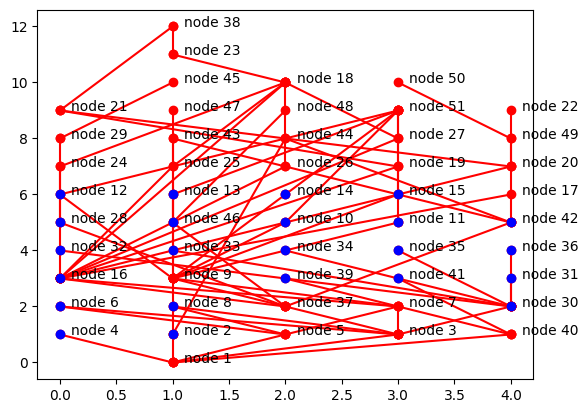

In [80]:
rr_13_1 = adjust_horisontal(step_1_13.rr, 1.0)
rr_13_2 = adjust_horisontal(rr_13_1, 0.5)
rr_13_3 = normalize_cols(rr_13_2)
draw(rr_13_3)

I cannot say that it looks _better_ than the final image from the previous part. But the most important is that current result doesn't contain any downgoing edge. All children and blockers are placed above parents and blocked nodes. That's an important achievement.

## Next steps

At the end of the previous part, we got 4 issues. Now, after solving one of them, we have _more_:


1. **Performance**. There's still a room for improvement. It's not cool to have things like `new_opts = {... for goal_id, opts in step.rr.node_opts.items()`. We visit literally all nodes in `rr` while update only some of them. This place (and, probably, several others) should be reviewed and rewritten.
2. **Multiple roots**. We need to re-check algorithm for graph containing multiple root nodes. We could have either several not-connected sub-graphs (a result of filtering, for example), or sub-graphs that have some intermediate connections between them. Probably, an energy-based logic would be more useful here. Nevertheless, we _may have_ to modify an existing `energy` function in a way that only the shortest edge is considered.
3. **Fake goals**. In order to draw edges properly, we need to add "fake goals" (intersection points between edge and current layer). Current version of algorithm knows nothing about it.
4. **Code cleanup**. It seems that a `previous` relation we've introduced here covers more cases than `children_of_new_layer` hack from the previous part. Most probably, we could remove `chlidren_of_new_layer` without missing any actual behavior.
5. **Horizontal adjustment tweaking**. It also _seems_ that the new generated graph could be additionally improved by horizontal adjustments. Is it true?